# **Final Project - Text-Mining COVID-19 data**

* **Course**: MIE1624 - Introduction to Data Science and Analytics
* **Name**: Sugumar Prabhakaran (**id**: 994126815)
* **Due Date**: 15 Apr 2021, 11:59 pm

## **0. References and Libraries**

### **0.1 References**

1. E. Eren, Maksim, N. Solovyev, C. Nicholas, and E. raff. (Apr 2020). <u>COVID-19 Literature Clustering</u>. Retrieved from: https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Data-Pre-processing.

2. Dataquest. (16 Apr 2019). <u>Tutorial: Text Classification in Python Using spaCy</u>. Retrieved from: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/.

3. M. Sawant. (9 Jul 2019). <u>Truncated Singular Value Decomposition (SVD) using Amazon Food Reviews</u>. Retrieved from: https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d.

4. J. Shaik. (17 Sep 2020). <u>Practical Implementation of K-means, Hierarchical, and DBSCAN Clustering On Dataset With Hyperparameter Optimization</u>. Retrieved from: https://medium.com/analytics-vidhya/practical-implementation-of-k-means-hierarchical-and-dbscan-clustering-on-dataset-with-bd7f3d13ef7f. 

5. D. Wolffram. (Apr 2020). <u>Topic Modeling: Finding Related Articles</u>. Retrieved from: https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles/log.

6. S. Li. (31 May 2018). <u>Topic Modeling and Latent Dirichlet Allocation (LDA) in Python</u>. Retrieved from: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24.




### **0.2 Import All Libraries**

In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 1. Data Cleaning
from tqdm.notebook import tqdm, tnrange         # for progress bar
!pip install langdetect                         # remove non-engl articles
from langdetect import detect

# 2.1 Exploratory Data Analysis
!pip install -U spacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
import spacy                                    # main text processing model
import scispacy                                 # biomed text processing models
import en_core_sci_lg                           # large biomed data pipeline
from spacy import displacy                      # to render tokens
from spacy.lang.en.stop_words import STOP_WORDS # for removing stopwords
from collections import defaultdict             # word-count dictionary
from wordcloud import WordCloud                 # visual word cloud

# 2.2 Pre-Processing, Feature Selection and Dim. Reduction
from sklearn.feature_extraction.text import TfidfVectorizer  #2.2 Pre-Processing
from sklearn.decomposition import TruncatedSVD               #2.2 Dim. Reduction

# 3. Model Implementation
from sklearn.cluster import KMeans           # 3.1 Cluster Model
from scipy.spatial.distance import cdist     # 3.1 Euclidean Distance
from sklearn.metrics import silhouette_score # 3.1 Silhoutte Score for tuning
from sklearn.manifold import TSNE            # 3.3 Visualizing Cluster Model
from sklearn.decomposition import LatentDirichletAllocation # 3.4 Topic Modelling
from sklearn.feature_extraction.text import CountVectorizer # 3.4 Topic Modelling

# EXECUTION TIME: 2 mins 30 secs

     |████████████████████████████████| 983kB 26.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=7dea63ec8784ca4f8fe91dbfa1fe22e2886e9410ded76d14176ed7750148e8bd
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 12.8MB 19.3MB/s 
     |████████████████████████████████| 460kB 36.4MB/s 
     |████████████████████████████████| 1.1MB 36.3MB/s 
     |████████████████████████████████| 9.1MB 33.3MB/s 
     |████████████████████████████████| 122kB 34.7MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=5c159d8fb9ad429621d21f9734cfed4dead0082f8478b203d52d8248245fb002
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catal

## **1. Data Cleaning**

The following steps were conducted:

1. Drop unnecessary columns and remove all duplicate and null rows.
2. Clean and filter **publish_time** column
3. Filter for papers with 'COVID-19' term mentioned in abstract 
4. Remove non-english papers
5. Reindex and save clean file as **metadata2.csv** for future access.

In [2]:
#import 'metadata.csv' file
path = '/content/drive/MyDrive/3. MIE1624 - Intro to Data Science/5. Final Project/'
df = pd.read_csv(path + 'metadata.csv')
df.info(verbose=True)           # look at null-count
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


### **1.1 Drop Unnecessary Columns and Remove Duplicate, Null Rows**

* Drop all columns except: **title, abstract, authors, publish_time, pdf_json_files**
* Drop all rows containing duplicate abstracts
* Drop all rows with null values

In [3]:
# extract only useful columns, drop duplicates and drop null values
df = df[['title','abstract','authors', 'publish_time', 'pdf_json_files']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
print('df shape:', df.shape, '\n')

df shape: (129526, 5) 



### **1.2 Clean Publish_Time**

* Convert datatype to **datetime64[Day]**
* Filter for articles publised since **01 Jan 2000**
* View time-lapse of published articles by year

df shape: (127522, 5) 



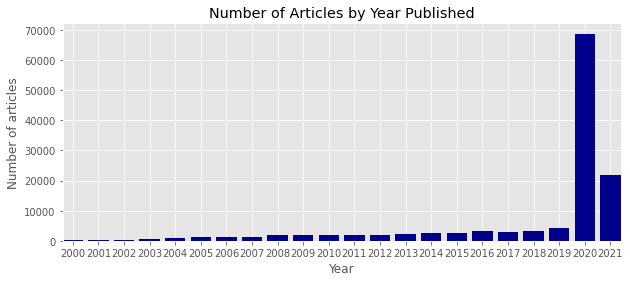

In [4]:
df.publish_time = df.publish_time.astype('datetime64[D]')  #convert to datetime
df = df[df.publish_time > '2000-01-01']     # only plot articles after 2001

# as a result, we drop approx. 4500 articles
print('df shape:', df.shape, '\n')

df.publish_time = df.publish_time.astype('datetime64[D]')  #convert to datetime
years = df.publish_time.dt.year.value_counts().index       #store for x-axis
height = df.publish_time.dt.year.value_counts().values     #store for bar height

# plot articles published per year
plt.style.use('ggplot')
plt.figure(figsize=(10, 4))
plt.bar(x=years, height=height, label='articles', color='darkblue')
plt.title('Number of Articles by Year Published')
plt.ylabel('Number of articles')
plt.xticks(np.arange(2000,2022))
plt.xlabel('Year')
plt.margins(x=0)
plt.show()

In [5]:
# since we won't lose much, we keep only papers after jan 2020
df = df[df.publish_time > '2020-01-01']     # we keep only articles after 2001

# as a result, we drop approx. 37000 articles
print('df shape:', df.shape, '\n')

df shape: (90365, 5) 



### **1.3 Filter for COVID-19 in Abstract**

Since there were over 37000 papers between 2000 and 2020, we will filter further by selecting only papers that contain a 'covid-19' term in their abstract.  This will focus our clustering efforts later.

In [6]:
#create set of possible covid-19 terms
covid19_terms = {'COVID19','COVID-19','2019-nCoV','2019-nCoV.',
                 'coronavirus disease 2019','Corona Virus Disease 2019',
                 'corona-virus disease 2019', '2019-novel Coronavirus',
                 'covid-19','covid19','SARS-CoV-2'}

# function to return boolean if text contains covid-19 term
def filter_covid_articles(text):
    for name in covid19_terms:
        if name.lower() in str(text).lower():
            return True
    return False

tqdm.pandas()               # progress bar for apply function to abstract
df['covid_related'] = df.abstract.progress_apply(filter_covid_articles)
print(df.covid_related.value_counts(), '\n')

# filter out 36000 non-covid articles
df = df[df['covid_related']==True]      
print('df shape:', df.shape)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



True     54055
False    36310
Name: covid_related, dtype: int64 

df shape: (54055, 6)


### **1.4 Remove Non-English Articles**

* Use **langdetect** library **detect** function so non-english papers can be filtered out

In [7]:
tqdm.pandas()                                     # add progress bar
df['language'] = df['title'].progress_map(detect) # determine lang for each cell

# EXECUTION TIME: 6 mins

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


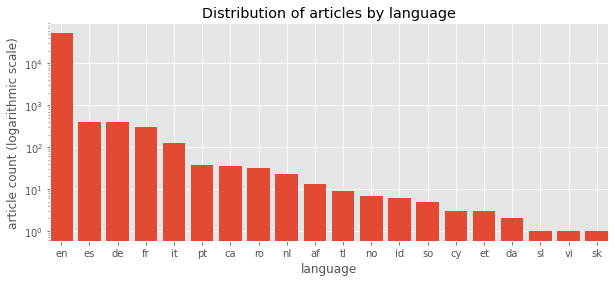

In [8]:
# plot distribution of papers by language:
#palette = sns.hls_palette(39, l=0.5) 
plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.bar(x=np.arange(len(df.language.value_counts())), 
        height=df.language.value_counts().values)
plt.title('Distribution of articles by language')
plt.xticks(np.arange(len(df.language.value_counts())), df.language.value_counts().index)
plt.xlabel('language')
plt.ylabel('article count (logarithmic scale)')
plt.yscale('log')
plt.margins(x=0)
plt.show()

In [9]:
# we remove all non-english papers
df = df[df.language == 'en']
df.language.value_counts()

en    52640
Name: language, dtype: int64

### **1.5 Reindex and Save MetaData File**

* Reindex and save as **metadata2.csv** for quick loading

In [10]:
df = df.reset_index(drop=True)
df = df[['title','abstract','publish_time']]
print('df.shape:', df.shape, '\n')
#df.to_csv(path + 'metadata2.csv', index=False)
df.head()

df.shape: (52640, 3) 



,title,abstract,publish_time
0,Therapeutic strategies in an outbreak scenario...,a novel coronavirus (2019-ncov) originating in...,2020-02-07
1,Artificial Intelligence (AI) applications for ...,background and aims: healthcare delivery requi...,2020-04-14
2,Coronavirus disease: challenges for psychiatry,coronavirus disease (covid-19) presents two ur...,2020-04-15
3,Practical Considerations When Performing Neuro...,"the coronavirus disease 2019, sars-cov-2 (the ...",2020-05-06
4,Extracorporeal Life Support Organization Coron...,the extracorporeal life support organization (...,2020-05-12


## **2. Exploratory Data Analysis & Visualizations**

Present 3 graphical figures that visualize aspects of the data that will be further explored.  How could these trends be used to extract trends of this type?  Consider how accessing data and visualizations will inform pre-processing.

First, I started by exploring other techniques for Natural Language Processing(NLP) since the data contains a lot of biomedical terminology.  The standard NLP processes may strip important digits and characters away, such as in: **'SARS-CoV-2'** and **'2019-nCoV'**.  As a result, my research through references 1 and 2 led me to find the scispaCy library.

1. **<u>scispaCy biomedical entities</u>**.  I then applied the scispaCy large biomedical model to identify entities within the text.  From the visual in 2.1, we can see the model identify words that match with the biomedical dictionary.  Also note that specific medical terms such as **'ace2-fc therapy'** and **'monoclonal antibody therapy'** are recognized as a single entity instead of 2 or three separate words.  This led me to experiment with a new way to tokenize the abstract data by using entities instead of bigrams or trigrams.  My assumption was that this could cut down on memory (RAM) issues as well.

2. **<u>WordCloud</u>**.  Next I vectorized using TF-IDF vectorizer and created a WordCloud based on the word counts.  From the word cloud, we can see that several key COVID-19 related terms appeared such as **mortality, treatment, impact, lockdown, model, vaccine, and intervention.**  These terms seem to be related to various distinct aspects of coronovirus such as:
  * how do we reduce transmission
  * what affects mortality rate
  * what are the impacts of COVID-19
  * what is effective for vaccine development

  * Based on this, I decided to do an unspervised clustering model to see if similar words and abstracts will cluster together in distinct groups.  Reference 1, 5 and 6 gave ideas on follow on steps to do topic modelling (to be discussed in next section).

3. **<u>Dimensionality Reduction</u>**.  Finally, in order to cluster this large data set and do further analysis, we need to speed up the computation time.  Initially, I attempted PCA but due to memory (RAM) issues, I choose Truncated Singular Value Decomposition (SVD).  The graph in this section shows the % of the variance explained by using only the top N features.  Based on this, I selected the number of components (N) for SVD to give atleast 50% of the variance.

In [11]:
#re-import in event of memory crash
#df2 = pd.read_csv(path + 'metadata2.csv')
#print('df2.shape:', df2.shape, '\n')
#df2.head()

### **2.1 Natural Language Processing (NLP) using scispaCy Entity Identification**


* Load **SciSpaCy** pipeline for biomedical vocabulary
* Visualize the identification of biomedical term entities using **displacy.render()**
* Update stopwords from sciscapcy to include custom stopwords and stopwords from NLTK libraries
* Create function to identify biomedical terms as 'entities', tokenize the entities and filter out stopwords and punctuation

In [11]:
#Reference: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/.

# load sciSpaCy model for biomed terminology
nlp = en_core_sci_lg.load(disable =['parser'])     
nlp.max_length = 500000          
# Execution Time: 30 seconds   

In [12]:

text= df.abstract[0] + ' covid-19'          # example text to render image
displacy.render(nlp(text), style='ent', jupyter=True)

In [13]:
# Reference 1: https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Data-Pre-processing

stopwords = list(STOP_WORDS)                    # imported from sciscpaCy
print("# of spacy stopwords:", len(stopwords))

#we want to add missing words from nltk to spacy_stopwords since it has more
nltk_stopwords = ["you're", "you've", "you'll", "you'd", "she's", "it's", 
                  'theirs', "that'll", 'having', 's', 't', 'don', "don't", 
                  "should've", 'd', 'll', 'm', 'o', 've', 'y', 'ain', 'aren', 
                  "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', 
                  "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
                  "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', 
                  "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 
                  "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', 
                  "won't", 'wouldn', "wouldn't"]
print("# of extra nltk stopwords:", len(nltk_stopwords))

# extra words found in research papers from Reference #1
custom_stopwords = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 
    'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 
    'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 
    'PMC', 'CZI', 'www']
print("# of extra custom stopwords:", len(custom_stopwords),'\n')

stopwords.extend(nltk_stopwords)      # combine lists into spacy list
stopwords.extend(custom_stopwords)
print("final # of words in spaCy stopwords:", len(stopwords))

# of spacy stopwords: 326
# of extra nltk stopwords: 56
# of extra custom stopwords: 26 

final # of words in spaCy stopwords: 408


In [14]:
# create function to recognize biomedical terminology as entities, 
# tokenize entities, filter out stopwords and lemmatize
def tokenizer(text):
    lemmas = [word.lemma_ for word in nlp(text) if str(word) not in stopwords]
    string = ' '.join(lemmas)
    entities = [str(entity) for entity in nlp(string).ents]
    return entities

### **2.2 Vectorization and Feature Importance**

* Use TF-IDF vectorizer to transform **df** into **vectorized_matrix**
* Generate a dataframe from vectorized data and use it to calculate word-count for each new vectorized feature (word) column
* Create WordCloud to view top 100 words in data set

In [15]:
#TF-IDF vectorizer using tokenizer function to tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=100)
vectorized_matrix = vectorizer.fit_transform(tqdm(df.abstract))
# store vectorized_matrix as .csv file as backup
#np.savetxt('vectorized_matrix.csv', vectorized_matrix.toarray(), delimiter=',')
print("vectorized_matrix shape:", vectorized_matrix.shape)
# EXECUTION TIME: 53 mins


vectorized_matrix shape: (52640, 2184)


In [16]:
# create dataframe to view vectorized data and obtain word counts
labels = vectorizer.get_feature_names()
vector_df = pd.DataFrame.sparse.from_spmatrix(vectorized_matrix, columns=labels)
vector_df.head()

,abdominal pain,ability,abnormal,abnormality,absence,absolute,absorption,abstract,abstract background,abundance,abundant,academic,academic medical center,acceptable,acceptance,access,accessibility,accumulate,accumulation,accuracy,accurate,ace-2,ace2,ace2 receptor,acquisition,action,activate,activation,active,active site,activity,actual,acute,acute kidney injury,acute lung injury,acute respiratory distress syndrome,acute respiratory failure,acute respiratory syndrome,acute respiratory syndrome coronavirus,acute respiratory syndrome-coronavirus-2,...,weekly,welfare,well-being,white,white blood cell,white blood cell count,widespread,willingness,wind,window,winter,witness,woman,word,work,worker,workflow,workforce,workload,workplace,world,world health organization,worldwide,worry,worsen,worsening,wuhan,wuhan city,year,york,york city,young,young adult,young age,young people,youth,zealand,zone,zoonotic,–
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.233504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212783,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Capture wordcount in freq_dict to generate wordcloud
freq_dict = defaultdict()

# word count of top 100 word counts in vector_df
word_count = vector_df.sum(axis=0).sort_values(ascending=False)[0:100]
for index, value in word_count.iteritems():
    freq_dict[index] = value    # convert word_count pd.Series to dictionary

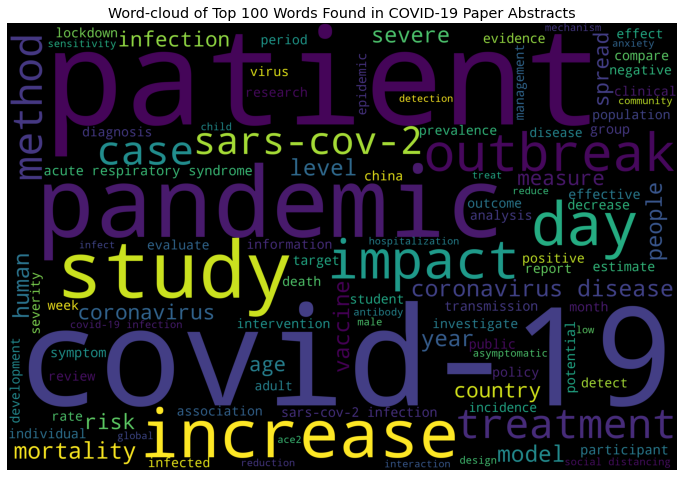

In [18]:
# Visualize word count using WordCloud
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=21).generate_from_frequencies(freq_dict)

plt.figure(figsize=(12,10))
plt.title("Word-cloud of Top 100 Words Found in COVID-19 Paper Abstracts")
plt.imshow(wordcloud)
plt.axis("off");
#plt.savefig('fig4_word_cloud.png', dpi=600)

### **2.3 Dimensionality Reduction and Feature Selection**

Initially, I attempted PCA but due to the size of the dataset, Google Colab was running out of RAM (memory) and crashing. As a result and as per reference 3, I used TruncatedSVD, which accepts sparse matrix (**vectorized_matrix**). 

The following dimensionality reduction/feature selection steps taken were:

* Reduce **vectorized_matrix** to **svd_reduced_data** using TruncatedSVD in order to reduce number of features while keeping significant amount of the variance (60%)
* Plot feature importance in terms of % variance explained of top SVD principle components

In [19]:
# Reference: https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d.

# reduce vectorized_matrix to n_components
components = 500
svd = TruncatedSVD(n_components=components, random_state=21)
svd_reduced_data = svd.fit_transform(vectorized_matrix)
print("svd_reduced_data shape:", svd_reduced_data.shape, '\n')  # view shape
# EXECUTION TIME: 30 secs

svd_reduced_data shape: (52640, 500) 



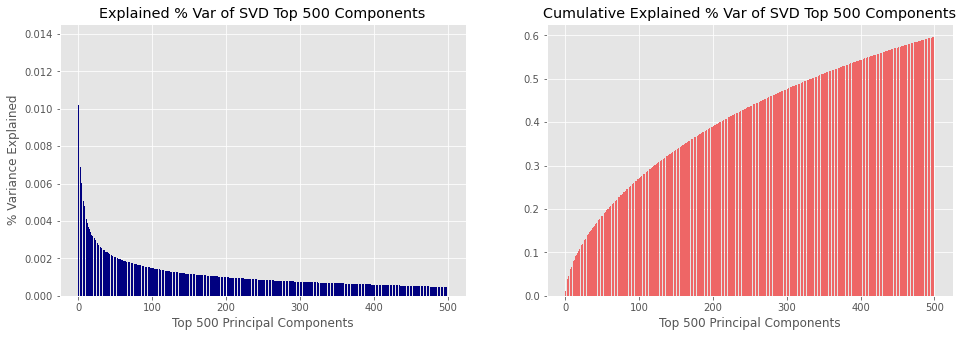

In [20]:
#plot of explained variance percentages and cumulative plot
plt.style.use('ggplot')
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].bar(x=np.arange(components), 
          height=svd.explained_variance_ratio_[:components], 
          color='navy')
ax[1].bar(x=np.arange(components), 
          height=np.cumsum(svd.explained_variance_ratio_[:components]),
          color='#EE6666')
ax[0].set_ylabel('% Variance Explained')
ax[0].set_ylabel('% Variance Explained')
for i in range(2):
    ax[i].set_xlabel(f'Top {components} Principal Components')
ax[0].set_title(f'Explained % Var of SVD Top {components} Components')
ax[1].set_title(f'Cumulative Explained % Var of SVD Top {components} Components')
#plt.savefig('fig-variance-explained.png', dpi=600)
plt.show()

## **3. Model Implementation**

Select a machine learning model (unsupervised or supervised) and justify your algorithm and approach.

* I selected the KMeans unsupervised clustering model since we don't have any labels for our data and literature, such as reference 1, indicates that it is a common approach for text-mining.  

* Since we have several biomedical terms with different frequencies, using KMeans may help us find associations between related words.

* Finally, KMeans is often paired with Latent Dirichlet Allocation (LDA) to do topic modelling, which is a process to determine the key topics that summarize a cluster.  As a result, I will implement LDA on my k-clusters to see if there is some overall theme associated with the cluster.

### **3.1 Hyperparameter Tuning: Unsupervised K-Means Model**

For K-Means clustering models, the hyperparameter to tune is the number of clusters ($k$).  In order to determine the optimal k-value, I will look at 2 methods from reference 4:

**<u>Intracluster distance</u>**

The average intracluster distance (denoted as $distance$), which is the average distance of all points to their closest centroid, calculated using the following formula:

$distance = \frac{\sum_{i\in M}{(\min_{x,c \in \mathbb{R}^n}{(||\boldsymbol{x_i} - \boldsymbol{c_j}||_n \text{ } \forall j \in k)}})}{|M|} \text{, where:} $

* $i:$ data point in set of all data points $M$
* $j:$ centroid in set of centroids $k$
* $\mathbb{R}^n:$ $n$ dimensional space of real numbers
* $x_i:$ vector coordinates of data point $i$ in $\mathbb{R}^n$
* $c_j:$ vector coordinates of centroid $j$ in $\mathbb{R}^n$
* $||\boldsymbol{x_i}-\boldsymbol{c_j}||_n:$ the "Ln" norm for computing euclidean distance in $n$-dimensions
* $|M|:$ cardinality of set $M$, which is the total number of data points $i$ 

In summary, it's calculated according to the following steps::
1. calculate the 'Ln' norm (euclidean distance in $n$ dimensions) for point $i$ to each centroid $j \in k$
2. select minimum distance from point i to nearest centroid
3. sum minimum distance for all points $i \in M$
4. divide by total number of points: $|M|$

**<u>Silhouette Score</u>**

The silhouette coefficient is a measure of how ideal the clustering is (**score range: $[-1,1]$**) and is calculated using:

$silhouette\_score = \frac{(b-a)}{\max(b,a)} \text{, where:}$

* $a:$ average intracluster distance (as per above)
* $b:$ average intercluster distance, which is the distance between clusters

From this simple metric, we can see that as:
* **<u>score</u>** $\rightarrow 1$: the clustering is good since points within clusters are grouped tightly (**small intracluster distance** $a$), while the clusters themselves are spread apart (**large intercluster distance** $b$).
* **<u>score</u>** $\rightarrow -1$: the clustering is poor since points within clusters are grouped loosly (**large intracluster distance** $a$), while the clusters themselves overlap. (**intercluster distance** $b \rightarrow 0$).

For the actual hyperparameter, we will tune values between 2 and 20 due to processing time and since there is risk of overfitting beyond that.

In [21]:
#Reference: https://medium.com/analytics-vidhya/practical-implementation-of-k-means-hierarchical-and-dbscan-clustering-on-dataset-with-bd7f3d13ef7f.

distances = []        # store intra_cluster_distances values for each k
sil_scores = []         # store silhouette scores
K = tnrange(2, 21)      # progress bar

for k in K:
    K.set_description(f"Calculating distances for {k} clusters")
    
    # fit model on svd_reduced_data and use 
    k_means = KMeans(n_clusters=k, 
                     n_init=5, 
                     random_state=21).fit(svd_reduced_data)
    
    #init = np.vstack((k_means.cluster_centers_, np.zeros((1,500))))
    # calculate avg distance of all points to nearest cluster
    distance = sum(np.min(cdist(svd_reduced_data, 
                                  k_means.cluster_centers_, 
                                  'euclidean'), axis=1))/df.shape[0]
    distances.append(distance)

    # silhouette score for comparison also
    sil_score = silhouette_score(svd_reduced_data, k_means.labels_)
    sil_scores.append(sil_score)

    # EXECUTION TIME: 42 mins

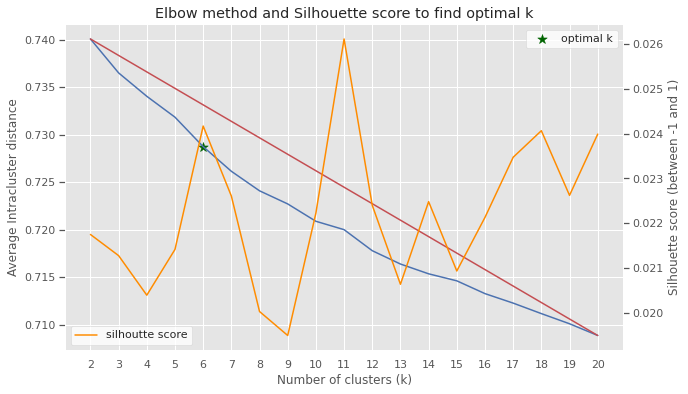

In [40]:
# Plot the elbow method to show variance of distortion with number of clusters k
X_line = [2, 20]
Y_line = [distances[0], distances[-1]]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(2,21), distances, 'b-')
ax.plot(X_line, Y_line, 'r')
ax.scatter(x=6, y=distances[4], marker='*', c='darkgreen', s=100, label = 'optimal k')
ax.set_xlabel('Number of clusters (k)')
ax.set_xticks(np.arange(2,21))
ax.set_ylabel('Average Intracluster distance')
ax.set_title('Elbow method and Silhouette score to find optimal k')
ax.set_xmargin(0.05)
ax.legend(facecolor='white')

# create twin axis for Silhouette score
ax2 = ax.twinx()
ax2.plot(np.arange(2,21), sil_scores, color='darkorange', label='silhoutte score')
ax2.set_ylabel('Silhouette score (between -1 and 1)')
ax2.legend(facecolor='white', loc=3)
ax2.grid(None)
#plt.savefig('fig-elbow-method.png', dpi=600)
plt.show()

### **3.2 Implementing Tuned Model: K-Means Clustering**

Now that we have the optimal k-value = 6, we implement the KMeans model and predict which cluster each data point belongs to.  This information is stored in the original df.

In [23]:
n_clusters = 6   # set # clusters from optimal value during hyperparameter tuning
k_means = KMeans(n_clusters=n_clusters, random_state=21).fit(svd_reduced_data)
y_pred = k_means.fit_predict(svd_reduced_data)
sil_score = silhouette_score(svd_reduced_data, k_means.labels_)
df['y_pred'] = y_pred
print("silhoutte score:", sil_score)
df.head()
# EXECUTION TIME: 1 mins 15 secs

silhoutte score: 0.02417356805406239


,title,abstract,publish_time,y_pred
0,Therapeutic strategies in an outbreak scenario...,a novel coronavirus (2019-ncov) originating in...,2020-02-07,4
1,Artificial Intelligence (AI) applications for ...,background and aims: healthcare delivery requi...,2020-04-14,3
2,Coronavirus disease: challenges for psychiatry,coronavirus disease (covid-19) presents two ur...,2020-04-15,3
3,Practical Considerations When Performing Neuro...,"the coronavirus disease 2019, sars-cov-2 (the ...",2020-05-06,3
4,Extracorporeal Life Support Organization Coron...,the extracorporeal life support organization (...,2020-05-12,3


In [24]:
#First, print distribution of cluster predictions
print(pd.Series(y_pred).value_counts()/len(y_pred), '\n')

#Get index for a sample of 10000 random data points since t-SNE calculations are 
#too intensive for full dataframe.  Further, t-SNE is more for visual representation anyway. 
index = np.random.choice(len(y_pred), 10000, replace=False)
y_slice = y_pred[index]
# compare random sampled predictions distribution to make sure balance is similar.
pd.Series(y_slice).value_counts()/len(y_slice)

3    0.425703
5    0.218142
4    0.162709
2    0.123556
0    0.054236
1    0.015653
dtype: float64 



3    0.4147
5    0.2241
4    0.1650
2    0.1241
0    0.0566
1    0.0155
dtype: float64

### **3.3 Visualize Clustering Model Implementation**

In order to visualize the data, the following steps were taken:

1. The full **vectorized_matrix** was transformed into **tsne_embedded_data** using *t-distributed Stocahstic Neighbor Embedding* (**t-SNE**), which is a dimensionality reduction method that will reduce data to two dimensions.

2. Once data is in two dimensions, each data point can be plotted on a two-dimensional scatter plot.

In [25]:
# embed sample of 10000 points from svd_reduced_data using t-SNE
tsne = TSNE(verbose=1, perplexity=50, random_state=21)
tsne_embedded_data = tsne.fit_transform(svd_reduced_data[index])
# EXECUTION TIME: 5 mins

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.726s...
[t-SNE] Computed neighbors for 10000 samples in 135.199s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.220731
[t-SNE] KL divergence after 250 iterations with early exaggeration: 119.019997
[t-SNE] KL divergence after 1000 iterations: 3.155223


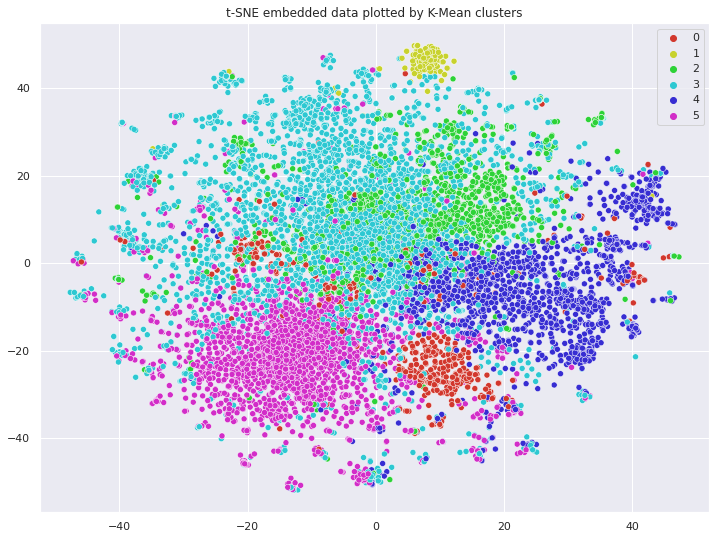

In [39]:
# Reference: https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Data-Pre-processing.

# Scatter Plot for K clusters
sns.set(rc={'figure.figsize':(12,9)})  # set figure size
palette = sns.hls_palette(n_clusters, l=0.5)    # create color palette with 10 colors
# generate scatter plot
sns.scatterplot(x=tsne_embedded_data[:,0], y=tsne_embedded_data[:,1], 
                hue=y_slice, legend='full', palette=palette)
plt.title('t-SNE embedded data plotted by K-Mean clusters')
#plt.savefig('fig-clusters.png', dpi=600)
plt.show()

### **3.4A Topic Modelling for Each Cluster**

The process of finding the words most associated with a particular cluster is called **topic modelling**.  In order to do this, we use the following steps:

1. Create a CountVectorizer for each of the 6 clusters and store in a list
2. Filter the full **df** by cluster number and vectorize each "sub_df".  Store vectorized data in list.
3. Create 6 LatentDirichlet Allocation (LDA) models for topic modelling and store in a list.
4. Run LDA model on corresponding vectorized data for respective clusters. Store results in a list.
5. Build a function that extracts topic words for each cluster and store in a list.

In [27]:
#References: https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles/log.
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24.

# 1. Create a CountVectorizers for each cluster and store in list
vectorizers = []        # list to store each of the vectorizers
pbar = tnrange(0, n_clusters)    # progress bar using tqdm range function

for i in pbar:
    pbar.set_description(f"Generating vectorizer for cluster {i}")
    vectorizer = CountVectorizer(tokenizer=tokenizer, min_df=50)
    vectorizers.append(vectorizer)

In [28]:
# 2. Vectorize df data that is filtered for each respective cluster
vectorized_cluster_data = []  # list to store vectorized data for each cluster

for cluster, vectorizer in enumerate(tqdm(vectorizers)):
    try:
        vectorized_cluster_data.append(
            vectorizer.fit_transform(df.loc[
                                             df['y_pred'] == cluster, 
                                             'abstract']))
    except Exception as e:
        print(f"Not enough data for cluster: {cluster}")
        vectorized_cluster_data.append(None)
# EXECUTION TIME: 7 mins 30 secs

In [29]:
#3. Generate LDA model for each cluster and store in list
num_topics = 10         # top 10 topics for each cluster
lda_models = []         # list to store each model
pbar = tnrange(n_clusters)      # progress bar based on number of clusters

for i in pbar:
    lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=10, 
                                    learning_method='online',verbose=False, 
                                    random_state=21)
    lda_models.append(lda_model)

In [30]:
#4. Apply LDA model to Vectorized data for each cluster and store in list
lda_topic_data = []     # list to store model results

for cluster, lda_model in enumerate(tqdm(lda_models)):
    if vectorized_cluster_data[cluster] != None:
        lda_data = lda_model.fit_transform(vectorized_cluster_data[cluster])
        lda_topic_data.append(lda_data)
# EXECUTION TIME: 32 secs

In [31]:
#Reference: https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Data-Pre-processing.

# 5. Functions for printing keywords for each topic
def cluster_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for i, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [32]:
# Call function and store topic keywords for each cluster in a list
all_keywords = []   # list to store all topic keywords

# loop through each cluster model results and apply function to extract keywords
for i, lda_model in enumerate(lda_models):
    if vectorized_cluster_data[i] != None:
        all_keywords.append(cluster_topics(lda_model, vectorizers[i]))

In [33]:
# print topic keywords for each cluster:
for i, keywords in enumerate(all_keywords):
    print(f"cluster {i}: {keywords}")

cluster 0: ['sensitivity', 'covid-19', 'specificity', 'antibody', 'sample', 'day', 'assay', 'positive', 'saliva', 'asymptomatic', 'detect', 'igg', 'seroprevalence', 'patient', 'accuracy', 'individual', 'specimen', 'negative', 'detection', 'level', 'neutralize', 'coronavirus', 'method', 'diagnosis']
cluster 1: ['student', 'pandemic', 'anxiety', 'medical', 'covid-19', 'college', 'knowledge', 'study', 'patient', 'medical student', 'report', 'symptom', 'increase', 'age', 'design', 'staff', 'potential']
cluster 2: ['covid-19', 'estimate', 'country', 'day', 'outbreak', 'case', 'policy', 'social distancing', 'infected', 'individual', 'prediction', 'reproduction', 'asymptomatic', 'lockdown', 'epidemic', 'population', 'temperature', 'model', 'transmission', 'travel', 'city', 'incidence']
cluster 3: ['participant', 'patient', 'increase', 'impact', 'age', 'anxiety', 'mortality', 'people', 'study', 'decrease', 'covid-19', 'public', 'pandemic', 'transmission', 'spread', 'healthcare', 'covid‐19']
cl

### **3.4B Repeat 3.4A with Different Vectorizer**

* try with min_df = 100, to get different (additional) topic keywords:

In [34]:
# 1. Create a CountVectorizers for each cluster and store in list
vectorizers = []        # list to store each of the vectorizers
pbar = tnrange(0, n_clusters)    # progress bar using tqdm range function

for i in pbar:
    pbar.set_description(f"Generating vectorizer for cluster {i}")
    vectorizer = CountVectorizer(tokenizer=tokenizer, min_df=100)
    vectorizers.append(vectorizer)



In [35]:
# 2. Vectorize df data that is filtered for each respective cluster
vectorized_cluster_data = []  # list to store vectorized data for each cluster

for cluster, vectorizer in enumerate(tqdm(vectorizers)):
    try:
        vectorized_cluster_data.append(
            vectorizer.fit_transform(df.loc[
                                             df['y_pred'] == cluster, 
                                             'abstract']))
    except Exception as e:
        print(f"Not enough data for cluster: {cluster}")
        vectorized_cluster_data.append(None)
# EXECUTION TIME: 7 mins 30 secs

In [36]:
#3. Generate LDA model for each cluster and store in list
num_topics = 10         # top 10 topics for each cluster
lda_models = []         # list to store each model
pbar = tnrange(n_clusters)      # progress bar based on number of clusters

for i in pbar:
    lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=10, 
                                    learning_method='online',verbose=False, 
                                    random_state=21)
    lda_models.append(lda_model)

In [37]:
#4. Apply LDA model to Vectorized data for each cluster and store in list
lda_topic_data = []     # list to store model results

for cluster, lda_model in enumerate(tqdm(lda_models)):
    if vectorized_cluster_data[cluster] != None:
        lda_data = lda_model.fit_transform(vectorized_cluster_data[cluster])
        lda_topic_data.append(lda_data)
# EXECUTION TIME: 32 secs

In [38]:
# Call function and store topic keywords for each cluster in a list
all_keywords = []   # list to store all topic keywords

# loop through each cluster model results and apply function to extract keywords
for i, lda_model in enumerate(lda_models):
    if vectorized_cluster_data[i] != None:
        all_keywords.append(cluster_topics(lda_model, vectorizers[i]))

# print topic keywords for each cluster:
for i, keywords in enumerate(all_keywords):
    print(f"cluster {i}: {keywords}")

cluster 0: ['covid-19', 'assay', 'day', 'patient', 'detect', 'detection', 'antibody', 'diagnosis', 'sample', 'specificity', 'saliva', 'positive', 'individual', 'sars-cov-2', 'sensitivity', 'seroprevalence', 'specimen', 'participant', 'rate', 'viral load', 'sars-cov-2 infection', 'level', 'prevalence', 'asymptomatic', 'infected']
cluster 1: ['student', 'covid-19', 'anxiety', 'level', 'study', 'medical', 'survey', 'outbreak', 'information', 'method', 'pandemic', 'investigate', 'increase', 'year', 'positive', 'participant']
cluster 2: ['model', 'covid-19', 'day', 'outbreak', 'transmission', 'estimate', 'epidemic', 'policy', 'social distancing', 'china', 'country', 'lockdown', 'infected', 'infection', 'contact', 'prediction', 'asymptomatic', 'rate', 'intervention', 'measure', 'temperature', 'pandemic', 'implement']
cluster 3: ['covid-19', 'pandemic', 'patient', 'participant', 'people', 'level', 'increase', 'child', 'day', 'adult', 'woman', 'impact', 'information', 'negative', 'transmission

## **4. Derive Insights to Tackle Outbreak**

Discuss and propose how scientists, doctors, nurses,healthcare professionals, industry and governments can best use the insights to assist in the fight against the COVID-19 pandemic. Use insights from your model to justify proposed policies or action items.

Several insights can be drawn from the topic modelling keyword results after the KMeansunsupervised clustering:

**<u>General Insights and Comments</u>**:  

* The KMeans Unsupervised clustering model that was implemented was quite effective at grouping similar papers together.  Industry, healthcare and government professionals could use the clustering results to select a sub-set of articles and papers to further study in-depth if they have a particular area of interest.  For example, the cluster on **factors affecting mortality** could be filtered and be the start of a new study.  From here, a different model could potentially be selected along with a new approach to do feature engineering.  

* For this model, I focused primarily focused on article abstracts because of the issues I had with computing time and memory (RAM) capacity.  In the future, I would look at other more advanced tools such as tensorflow and GPUs to speed up the analysis.

* **Note 1**. Please note that these insights are based on the association of related words and the frequency in which they occur and so it is difficult to make conclusive recommendations.  All we have is a probable relationship since there are many papers discussing those particular key-words.  However, we can't conclude that the word has a positive, negative or neutral relationship to the overall theme. For example, **age group** appeared in the first cluster as a potential factor affecting mortality but we don't know if the papers say that age is related to mortality or not.  

* **Note 2**.  I ran section 3.4 twice: once with vectorizers using min_df = 50 words and again with min_df = 100 words.  Both methods produced interesting keywords with significant overlap but I have kept some of the older words as well since they support the insights.

**<u>Specific Insights from Each Cluster Topic Keywords</u>**

Based on the keywords for each cluster, I identified an overarching *theme*, which is highlighted in bold.  Please read on for insights for each cluster:

* **<u>Cluster 0 - COVID-19 Detection & Screening</u>**:
  * Cluster 0 contains different indicators and factors that improve COVID-19 screening.  For example, testing saliva using assay and igg antibody tests seem to be related to improving detection and accuracy.  Further, seroprevalence (viral load), has a relation to detection and asymptomatic patients.
  * This information could be useful to both government health policy professionals and hospital administrators since better testing and detection will help to contain transmission.

* **<u>Cluster 1 - COVID-19 Impact on Education</u>**:
  * Cluster 1 is a concentration of articles that discuss the impact on students such as elementary and college aged students, and is linked to anxiety.  Further, educational techniques such as in-person learning, interactive learning and learning activities are mentioned in these studies. 
  * These could be useful for teachers and educators to develop better learning environments, as well as government officials to understand risks and impact of online-learning.

* **<u>Cluster 2 - Factors Affecting Transmission</u>**: 
  * This cluster contains policy measures such as social distancing, lockdown, contact tracing, travel restrictions and testing that could help reduce transmission.  There also seems to be a link between population, urban density and temperature to the rate of transmission.
  * This information could be used by senior government officials to determine policy actions to control the spread of the virus.

* **<u>Cluster 3 - General Impact</u>**: 
  * This cluster is perhaps the most broad and did not produce the most focused keywords.  There seems to be a link between general anxiety levels in the public and potential lack of knowledge/information about risks and transmission. There is some mention about impact to women and children, possibly related to day care.  
  * Again, governments and health officials could use this knowledge to increase advertising and information campaigns to better educate the public.

* **<u>Cluster 4 - Vaccine-virus interaction</u>**:
  * Cluster 4 contains research papers focused on understanding the virus and how vaccines could potentially counteract them.
  * It appears that the virus binds to the ace2 receptor, which is a protein on the surface of many cells.  
  * There seems to be a link between targeting the protease in the virus for drug effectiveness.  Further, there have been studies on chloroquine to treat the virus.
  * This information could be used further by researchers as part of vaccine development.

* **<u>Cluster 5 - Factors Affecting Mortality Rate</u>**:
  * Cluster 5 contains factors such as age group, type of treatment, severity of symptoms and mechanical ventilation that all seem to be related to mortality.  Further, c-reactive protein levels (CRP), tocilizumab receptor antibodies, and level of IL-6 inhibitors may have link to onset of acute respiratory distress syndrome (ARDS) and mortality.
  * This information could support medical staff during triage and treatment to understand who the high-risk patients are and whether to allocate limited resources like ventilators. 



